In [1]:
import dynet_config
dynet_config.set(autobatch=True)

In [2]:
import dynet as dy
import numpy as np
from time import time
import torch
from torch import nn
from fastprogress import progress_bar,  master_bar
from fastai_dynet.models import *
import PIL
from pprint import pprint
from matplotlib import pyplot as plt

In [3]:
#export
from exp.nb_01 import *

def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return x_train,y_train,x_valid,y_valid

def normalize(x, m, s): return (x-m)/s

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
PIL.Image.fromarray((127*(1.0-x_train.reshape(-1, 28, 28)[50])).astype(np.uint8), mode='L')


In [6]:
#export
class Dataset:
    def __init__(self, xs, ys, shuffle=True):
        assert len(xs) == len(ys)
        self.xs, self.ys = xs, ys
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, i):
        return self.xs[i], self.ys[i]
    def __iter__(self):
        if self.shuffle: idxs = np.random.permutation(len(self))
        else:       idxs = list(range(len(self)))
        for i in range(len(self)):
            yield self[idxs[i]]
    def iter_batches(self, bs=64, shuffle=True):
        if shuffle: idxs = np.random.permutation(len(self))
        else:       idxs = list(range(len(self)))
        batch_start = 0
        while batch_start<len(self):
            yield self[batch_start:batch_start+bs]
            batch_start += bs
            
    def dataloader(self, bs=64, shuffle=True):
        return Dataloader(self, bs, shuffle)
            
    

class Dataloader:
    def __init__(self, dataset, bs=64, shuffle=True):
        self.ds = dataset
        self.bs = bs
        self.shuffle = shuffle
        
    def __len__(self):
        return int(np.ceil(len(self.ds)/self.bs))
        
    def __iter__(self):
        if self.shuffle: idxs = np.random.permutation(len(self.ds))
        else:       idxs = list(range(len(self.ds)))
        batch_start = 0
        while batch_start<len(self.ds):
            bx, by = self.ds[idxs[batch_start:batch_start+self.bs]]
            yield list(bx), by
            batch_start += self.bs
        
class Databunch:
    def __init__(self, train_ds, valid_ds, test_ds=None, bs=64):
        self.train_ds, self.valid_ds, self.test_ds = train_ds, valid_ds, test_ds
        self.train_dl = self.train_ds.dataloader(bs, shuffle=True)
        self.valid_dl = self.valid_ds.dataloader(bs, shuffle=False)
        if self.test_ds:
            self.test_dl = self.test_ds.iter_batches(bs, shuffle=False)
            
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
data = Databunch(train_ds, valid_ds, bs=64)

In [7]:
#export
from functools import partial

class Sequential(Module):
    def __init__(self, *layer_gens, parent=None, name=None, **kwargs):
        super().__init__(parent, **kwargs)
        self.layers = [l(parent=self) if l.__qualname__=='Module.create.<locals>.init' else l for l in layer_gens ]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

class Input(Module):
    def __init__(self, parent): super.__init__(parent)
    def __call__(self, x):      return dy.inputVector(x)
    
class SimpleModel(Module):
    def __new__(cls, *args, **kwargs):
        return super(cls, SimpleModel).__new__(cls, is_top=True, **kwargs)
    def __init__(self, n_in, n_hid, n_out, parent=None, **kwargs):
        super().__init__(parent)
        self.lin1 = Linear(n_in, n_hid)
        Linear(n_hid, n_out, activ=None, parent=self, name='lin2')
        
    def __call__(self, x):
        x = dy.inputTensor(x)
        return self.lin2(self.lin1(x))

def flatten(x):
    bs = x.dim()[-1]
    n_elem = np.prod(x.dim()[0])
    return dy.reshape(x, (n_elem,), batch_size=bs)

def avg_pool_2d(x):
    return dy.mean_dim(x, [0,1], False)

class Lambda(Module):
    def __init__(self, func, parent=None, name=None):
        name = name or func.__name__
        super().__init__(self, parent, name)
        self.func = func
        
    def __call__(x):
        return self.func(x)

class BatchNorm(Module):
    def __init__(self, nc, parent=None, name=None):
        super().__init__(parent, name)
        self.nc = nc
        self.mults = self.params.add_parameters((1, 1, nc), init=1)
        self.adds = self.params.add_parameters((1, 1, nc), init=0)
        self.mean = EWMA(init=np.zeros((1, 1, nc, 1)))
        self.std = EWMA(init=np.zeros((1, 1, nc, 1)))

        
    def update_stats(self, x):
        m = dy.reshape(dy.mean_dim(x, [0,1], True), (1, 1, self.nc))
        s = dy.reshape(dy.std_dim(x, [0,1], True), (1, 1, self.nc))
        if np.random.binomial(1, 0.05):
            #dy.forward([m, s])
            self.mean.update(m.npvalue())
            self.std.update(s.npvalue())
        return m, s
    
    def __call__(self, x):
        if self._training:
            mean, std = self.update_stats(x) 
        else:
            mean, std = dy.inputTensor(self.mean.value), dy.inputTensor(self.std.value)
        return dy.cmult(dy.cdiv(x - mean, std), self.mults) + self.adds
    
    def __repr__(self):
        return f"batch normalization layer: number of channels={self.nc}"
    
class LayerNorm(Module):
    def __init__(self, nc, eps=1e-5, parent=None, name=None):
        super().__init__(parent, name)
        self.nc = nc
        self.eps = eps
        self.mults = self.params.add_parameters((1, 1, nc), init=1)
        self.adds = self.params.add_parameters((1, 1, nc), init=0)
        
    def __call__(self, x):
        mean = dy.reshape(dy.mean_dim(x, [0,1], False), (1, 1, self.nc))
        std = dy.reshape(dy.std_dim(x, [0,1], False), (1, 1, self.nc))
        return dy.cmult(dy.cdiv(x - mean, std + self.eps), self.mults) + self.adds
        
    
class Conv2d(Module):
    def __init__(self, c_in, c_out, ksize, stride=1, parent=None, name=None):
        super().__init__(parent, name)
        self.stride = stride
        self.kernel = self.params.add_parameters((ksize, ksize, c_in, c_out), init='he', name='kernel')
        self.bias = self.params.add_parameters(c_out, init=0, name='bias')
        
    def __call__(self, x):
        return dy.conv2d_bias(x, self.kernel, self.bias, (self.stride, self.stride))
    


In [8]:
train_ds, valid_ds = Dataset(x_train.reshape(-1, 28, 28), y_train), Dataset(x_valid.reshape(-1, 28, 28), y_valid)
data = Databunch(train_ds, valid_ds, bs=64)
x = train_ds.xs[0]
bx, by = next(iter(data.train_dl))
m = Sequential(dy.inputTensor, Conv2d(1, 8, 5, stride=2), dy.rectify, Conv2d(8, 16, 3, stride=1), dy.rectify,\
               Conv2d(16, 32, 3, stride=2), dy.rectify, Conv2d(32, 32, 3, stride=2), \
               avg_pool_2d, Linear(32, 10),\
               is_top=True)

learn = Learner(m, opt, data, batching='minibatch')
loss = learn.loss_batch(bx, by)
loss.backward()
m.params.parameters_list()[-1].grad_as_array()

NameError: name 'Learner' is not defined

In [ ]:
opt = dy.SimpleSGDTrainer(m.params, learning_rate=4e-2)
learn = Learner(m, opt, data, batching='autobatch', metrics=[accuracy])
learn.callbacks[0].beta = 0.9
learn.fit(1)

In [ ]:
opt = dy.SimpleSGDTrainer(m.params, learning_rate=4e-2)
learn = Learner(m, opt, data, batching='minibatch', metrics=[accuracy])
learn.callbacks[0].beta = 0.9
learn.fit(3)

In [26]:
opt = dy.SimpleSGDTrainer(m.params, learning_rate=4e-1)
learn = Learner(m, opt, data, batching='autobatch', metrics=[accuracy])
learn.callbacks[0].beta = 0.9
learn.fit(3)

loss,accuracy
0.101,0.970
0.141,0.955
0.094,0.973


In [25]:
dy.dynet_config.set_gpu()
dy.dynet_config.gpu()

True

In [9]:
class CancelEpochException(Exception): pass
class CancelTrainException(CancelEpochException): pass
class CancelBatchException(Exception): pass

class Learner:
    def __init__(self, model, trainer, data, loss_func=None, batching='autobatch', cbfs=[], metrics=[]):
        self.model,self.trainer,self.data,self.loss_func,self.batching = model,trainer,data,loss_func,batching
        self.callbacks = [cbf(self) for cbf in cbfs]
        self.callbacks.append(MetricsSummer(self, metrics=metrics))
        self.callbacks.append(Recorder(self, metrics=metrics))
        if not self.loss_func:
            if batching == 'autobatch':
                self.loss_func = dy.pickneglogsoftmax
            elif batching == 'minibatch':
                self.loss_func = dy.pickneglogsoftmax_batch
        self._test = 1
        
    @property            
    def output(self):
        if self.batching == 'autobatch':
            return [out.npvalue() for out in self._output]
        elif self.batching == 'minibatch':
            return np.rollaxis(self._output.npvalue(), axis=-1)
    
    @output.setter
    def output(self, val):
        self._output = val
      
    def loss_batch(self, bx, by):
        dy.renew_cg()
        if self.batching=='autobatch':
            losses, outputs = [], []
            for x, y in zip(bx, by):
                out = self.model(x)
                outputs.append(out)
                losses.append(self.loss_func(out, y))
            self.output = outputs
            return dy.esum(losses)/len(losses)
        elif self.batching=='minibatch':
            out = self.model(bx)
            self.output = out
            return dy.sum_batches(self.loss_func(out, by))/len(by)
        else: 
            raise "invalid batching option"
        
    def pred_batch(self, bx, by):
        dy.renew_cg()
        if self.batching=='autobatch':
            outputs = []
            for x, y in zip(bx, by):
                outputs.append(self.model(x))
            dy.forward(outputs)
            return [out.npvalue() for out in outputs]
        elif self.batching=='minibatch':
            return np.rollaxis(self.model(bx).npvalue(), axis=-1)
        
    def one_batch(self, bx, by):
        self("on_batch_begin")
        loss = self.loss_batch(bx, by); self("on_forward_bagin")
        loss.forward();                 self("on_backward_begin", loss.value(), by)
        if self.mode == 'eval':         return
        loss.backward();                self("on_backward_end")  
        self.trainer.update();               self("on_batch_end")
        
    def all_batches(self, dl):
        self("on_epoch_begin")
        for bx, by in progress_bar(dl, parent=self.mbar):
            try:
                self.one_batch(bx, by)
            except CancelEpochException:
                break
        self("on_epoch_end")
            
    def fit(self, n_epochs):
        self.mbar = master_bar(range(n_epochs))
        self("on_train_begin")
        for epoch in self.mbar:
            self.epoch = epoch
            try:
                self.train()
                self.evaluate()
            except CancelTrainException:
                break
            
    def evaluate(self):
        self.mode = 'eval'
        self.all_batches(self.data.valid_dl)
        
    def train(self):
        self.mode = 'train'
        self.all_batches(self.data.train_dl)
            
    def __call__(self, event, *args, **kwargs):
        for cb in self.callbacks:
            cb(event, *args, **kwargs)
            
    def __getattr__(self, attr):
        for cb in self.callbacks:
            if cb.name() == attr:
                return cb

In [49]:
class EWMA:
    def __init__(self, beta=0.9, init=0):
        self.beta = 0.9
        self._value, self.n = 0, init
        
    def update(self, val):
        self.n += 1
        self._value = (self.beta*self._value + (1-self.beta)*val)
        return self.value
    
    @property
    def value(self):
        return self._value/(1-self.beta**self.n)

class Averager:
    def __init__(self, init=0):
        self._sum, self.N = init, 0
        
    def update(self, val, n=1):
        self._sum += val*n
        self.N += n
        return self.value
    
    @property    
    def value(self):
        return self._sum/self.N


[-2.266259 -0.767566  2.09503  -0.788047 ...  0.293275 -0.775075 -0.704895  1.076352]
0.08081518059954435 0.08081518059954435


In [120]:
from collections import defaultdict, namedtuple
from fastprogress import master_bar, progress_bar
class Callback:
    _order = 0
    def __init__(self, learn):
        self.learn = learn
     
    @classmethod
    def create(cls, *args, **kwargs):
        def init(learn):
            return cls(learn=learn, *args, **kwargs)
        return init
    
    def __call__(self, event, *args, **kwargs):
        f = getattr(self, event, None)
        if f: return f(*args, **kwargs)
    
    @classmethod 
    def name(cls):
        return cls.__name__.lower()

class ProgressBar(Callback):
    def __init__(self, learn):
        super().__init__(learn)
        
    def on_train_begin(self):
        self.mb = master_bar()
    
    def on_epoch_begin(self):
        pass

def accuracy(inp, targ):
    max_idxs = np.argmax(inp, axis=-1)
    return np.sum(np.equal(max_idxs, targ))/targ.shape[0]

class MetricsSummer(Callback):
    def __init__(self, learn, metrics=[], beta=0.9):
        super().__init__(learn)
        self.metrics = metrics
        self.beta = beta
        #self.totals = defaultdict(int)
        
    def on_train_begin(self):
        self.learn.mbar.write(['loss'] + [met.__name__ for met in self.metrics], table=True)
        
    def on_epoch_begin(self):
        self.avgs = defaultdict(Averager)
        self.smooth = EWMA(self.beta)
        self.n_data = 0
        
    def on_backward_begin(self, loss, by):
        self.learn.mbar.child.comment = f"{self.smooth.update(loss): 0.4f}"
        self.n_data += len(by)
        self.avgs['loss'].update(loss, len(by))
        if self.learn.mode == 'train': return
        for met in self.metrics:
            self.avgs[met.__name__].update(met(self.learn.output, by), len(by))
        #raise CancelTrainException
            
    def on_epoch_end(self):
        if self.learn.mode=='eval':
            self.learn.mbar.write([f'{v.value:0.3f}' for k, v in self.avgs.items()], table=True)
            for k, v in self.avgs.items():
                self.learn.recorder.records[k].valid.append(v.value)
            
Records = namedtuple('records', "train valid", defaults=[[], []])
class Recorder(Callback):
    def __init__(self, learn, metrics, beta=0.9):
        super().__init__(learn)
        self.metrics = metrics
        self.beta = beta
        
    def on_train_begin(self):
        self.records = defaultdict(lambda: Records(train=[], valid=[]))
        
    def on_epoch_begin(self):
        if self.learn.mode=='train':
            self.avgs = defaultdict(lambda: EWMA(self.beta))
        
    def on_backward_begin(self, loss, by):
        if self.learn.mode=='train':
            self.records['loss'].train.append(self.avgs['loss'].update(loss))
            for met in self.metrics:
                self.records[met.__name__].train.append(self.avgs[met.__name__].update(met(self.learn.output, by)))
            
    def plot(self):
        fig, axes = plt.subplots(len(self.records), 1)
        N = len(self.learn.data.train_dl)
        for (met, records), ax in zip(self.records.items(), axes):
            ax.plot(range(len(records.train)), records.train, label='training')
            ax.plot(range(N, (len(records.valid)+1)*N, N), records.valid, label='validation')
            ax.legend()
            fig.show()
            

In [121]:
m = Sequential(dy.inputTensor, Linear(28**2, 128, activ=None), dy.rectify, Linear(128, 10, activ=None) , is_top=True)
print(m)
trainer = dy.SimpleSGDTrainer(m.params)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
data = Databunch(train_ds, valid_ds, bs=64)

learn = Learner(m, trainer, data, batching='minibatch', metrics=[accuracy])


Linear layer: in=784, out=128, activation=no_op
Linear layer: in=128, out=10, activation=no_op


In [130]:
learn.recorder.beta = 0.1
learn.fit(5)

loss,accuracy
0.074,0.979
0.078,0.978
0.075,0.979
0.078,0.978
0.076,0.980


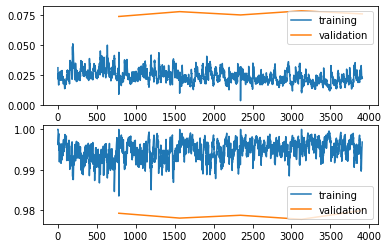

In [131]:
learn.recorder.plot()


In [132]:
Records(train=[], valid=[])

records(train=[], valid=[])

In [ ]:
x, y = next(iter(learn.data.train_dl))
dy.renew_cg()
x = dy.inputTensor(x.T)
x.dim()


In [ ]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid, shuffle=False)

In [ ]:

dy.renew_cg()
print(dy.inputTensor(x_train[:10], batched=True).dim())
print(dy.inputTensor([x_train[i] for i in range(10)]).dim())

In [ ]:
dy.inputTensor(train_ds[0][0]).dim(), dy.inputTensor(train_ds[:1][0], batched=True).dim()

In [ ]:
def evaluate(model, ds, loss_func, bs=64):
    loss_sum, n_cor = 0, 0
    for bx, by in ds.iter_batches(bs):
        losses, logits = [], []
        dy.renew_cg()
        for x, y in zip(bx, by):
            out = m(x)
            losses.append(loss_func(out, y))
            logits.append(out)
        dy.forward(logits)
        loss_sum += dy.esum(losses).value()
        n_cor += sum(np.argmax(log.npvalue()) == y for log, y in zip(logits, by))
    return loss_sum/len(ds), n_cor/len(ds)

evaluate(m, valid_ds, dy.pickneglogsoftmax)

In [ ]:
#22 seconds
m = Model1(28**2, 128,  10)
n_epochs = 3
bs = 64
trainer = dy.SimpleSGDTrainer(m.params, learning_rate=0.1)
loss_func = dy.pickneglogsoftmax
def fit():
    for epoch in range(n_epochs):
        for bx, by in train_ds.iter_batches(bs):
            loss = m.loss_batch(bx, by, dy.pickneglogsoftmax_batch, batching='minibatch')
            #print(loss.value())
            loss.forward()
            loss.backward()
            trainer.update()
        avg_loss, acc = evaluate(m, valid_ds, loss_func=dy.pickneglogsoftmax)
        print(epoch, f' loss: {avg_loss}, accuracy: {acc}')
                
fit() 

In [ ]:
#20 seconds
m = Model1(28**2, 128,  10)
n_epochs = 3
bs = 64
trainer = dy.SimpleSGDTrainer(m.params, learning_rate=0.1)
loss_func = dy.pickneglogsoftmax
def fit():
    for epoch in range(n_epochs):
        for bx, by in train_ds.iter_batches(bs):
            loss = m.loss_batch(bx, by, dy.pickneglogsoftmax, batching='autobatch')
            loss.forward()
            loss.backward()
            trainer.update()
        avg_loss, acc = evaluate(m, valid_ds, loss_func=dy.pickneglogsoftmax)
        print(epoch, f' loss: {avg_loss}, accuracy: {acc}')
                
fit() 

In [ ]:
dy.renew_cg

In [ ]:
bx, by = train_ds[:10]
list(zip(bx, by))

In [ ]:
trainer.learning_rate = 0.1
?trainer.restart